In [1]:
!pip install torchvision
from UTKFaceDataset import *
from UTKFaceModelTrainer import *
from UTKFaceUtils import *
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Define the transformation pipeline
# https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/#
# if no image is provided
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5904, 0.4462, 0.3769], std=[0.2177, 0.1899, 0.1799])
])

# balanced dir_path, transformed for vgg
dataset = UTKFaceDataset(dir_path='UTKFACE', transform=data_transforms)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders for train and test sets
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

# Create a random sampler for the train dataset
# set to a small number for troubleshooting
val_sampler = torch.utils.data.RandomSampler(val_dataset, replacement=True, num_samples=32)

val_sample_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

# device
device = "cpu"

In [4]:
# using model package
from model import *
vgg16 = Model(model_name = "vgg16", version = 1, num_classes = 116, pretrained = True)
model_file_name = "vgg16_pretrained_1.pth"
vgg16.load_state_dict(torch.load(model_file_name))

Using cache found in /home/repl/.cache/torch/hub/pytorch_vision_v0.9.0


<All keys matched successfully>

In [8]:
import requests 
from PIL import Image 
from torchvision import transforms 
from torchvision.transforms import ToTensor
from io import BytesIO 
import torch
import matplotlib.pyplot as plt 
import numpy as np

def inference(model, path, input_type='url'): 
    model.eval() 
    with torch.no_grad(): 
        if input_type == 'url': 
            response = requests.get(path) 
            img = Image.open(BytesIO(response.content)) 
            
            # Preprocess the image
            preprocess = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5904, 0.4462, 0.3769], std=[0.2177, 0.1899, 0.1799])
            ])
            img_t = preprocess(img)
            img_u = torch.unsqueeze(img_t, 0)

            # Run the model on the image
            with torch.no_grad():
                img_u = img_u.to(device)
                outputs = model(img_u)
                softmax_outputs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(softmax_outputs, 1)

            # Display the image and prediction
            plt.imshow(np.transpose(img_t.numpy(), (1, 2, 0)))
            plt.title('Predicted: {}'.format(predicted[0]))
            plt.axis('off')
            plt.show()
            
        elif input_type == 'loader': 
            for i, data in enumerate(path): 
                images = data['image'].to(device) 
                labels = data['label']['age'].to(device) 
                outputs = model(images) 
                softmax_outputs = torch.softmax(outputs, dim=1) 
                _, predicted = torch.max(softmax_outputs, 1)

            # Display the images and prediction
            fig = plt.figure(figsize=(16, 16))
            for j in range(16): # loop over all images in the batch
                ax = fig.add_subplot(4, 4, j+1) # change to 4x4 plot
                ax.imshow(np.transpose(images[j].cpu().numpy(), (1, 2, 0)))
                ax.set_title('Predicted: {}, Actual: {}'.format(predicted[j], labels[j]))
                ax.axis('off')
            plt.show()
            
        elif input_type == 'file':
            # Load image
            img = Image.open(path)

            # Preprocess the image
            preprocess = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5904, 0.4462, 0.3769], std=[0.2177, 0.1899, 0.1799])
            ])
            img_t = preprocess(img)
            img_u = torch.unsqueeze(img_t, 0)

            # Run the model on the image
            with torch.no_grad():
                img_u = img_u.to(device)
                outputs = model(img_u)
                softmax_outputs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(softmax_outputs, 1)

            # Display the image and prediction
            plt.imshow(np.transpose(img_t.numpy(), (1, 2, 0)))
            plt.title('Predicted: {}'.format(predicted[0]))
            plt.axis('off')
            plt.show()
        


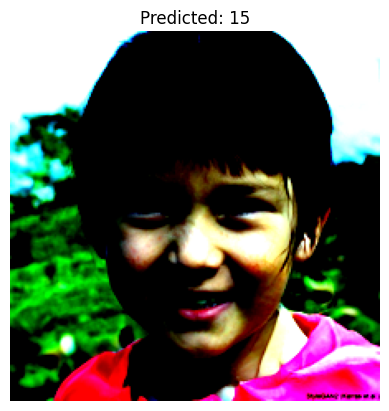

In [23]:
inference(vgg16, path='https://thispersondoesnotexist.com/', input_type="url")

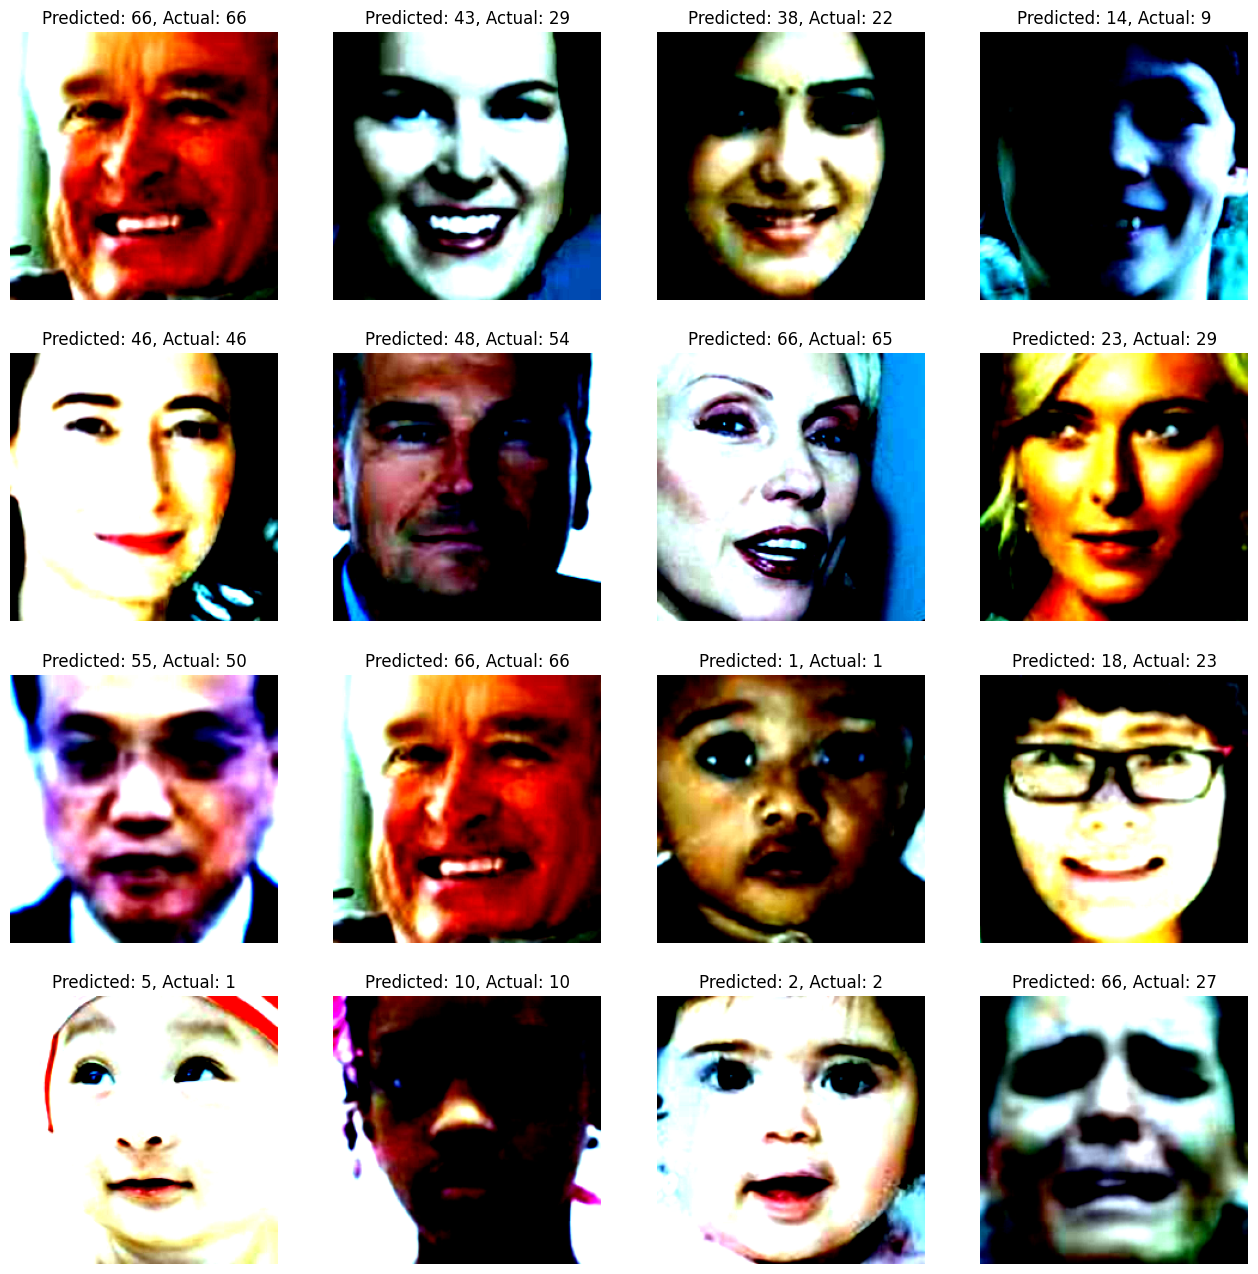

In [13]:
inference(vgg16, path=val_sample_loader, input_type="loader")

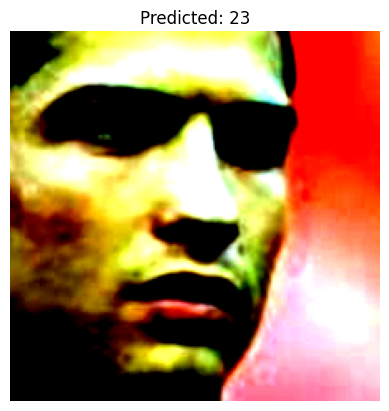

In [21]:
inference(vgg16, path='UTKFACE_balanced/25_0_4_20170117195016421.jpg.chip.jpg', input_type="file")